In [1]:
# Advance Lane Finding

In [2]:
#1.-Camera Calibartion

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2
import os
%matplotlib inline

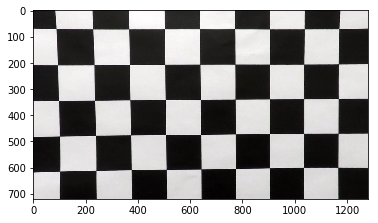

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
object_points = [] #real points 3D
image_points = [] #point of the different images 2D

obj_points = np.zeros((6*9,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
total = 0
for image in images:
    
    #read each image
    img = mpimg.imread(image) 

    #convert to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #find corner for the cheesboard
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(obj_points)

#calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)

#test the calibration a plot image1
test_image = mpimg.imread('camera_cal/calibration1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
plt.imshow(dst)



In [5]:
test_image = mpimg.imread('test_images/straight_lines1.jpg') 
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


In [6]:
#2.- COLOR TRANSFORM, GRADIENTS FOR BINARY IMAGE

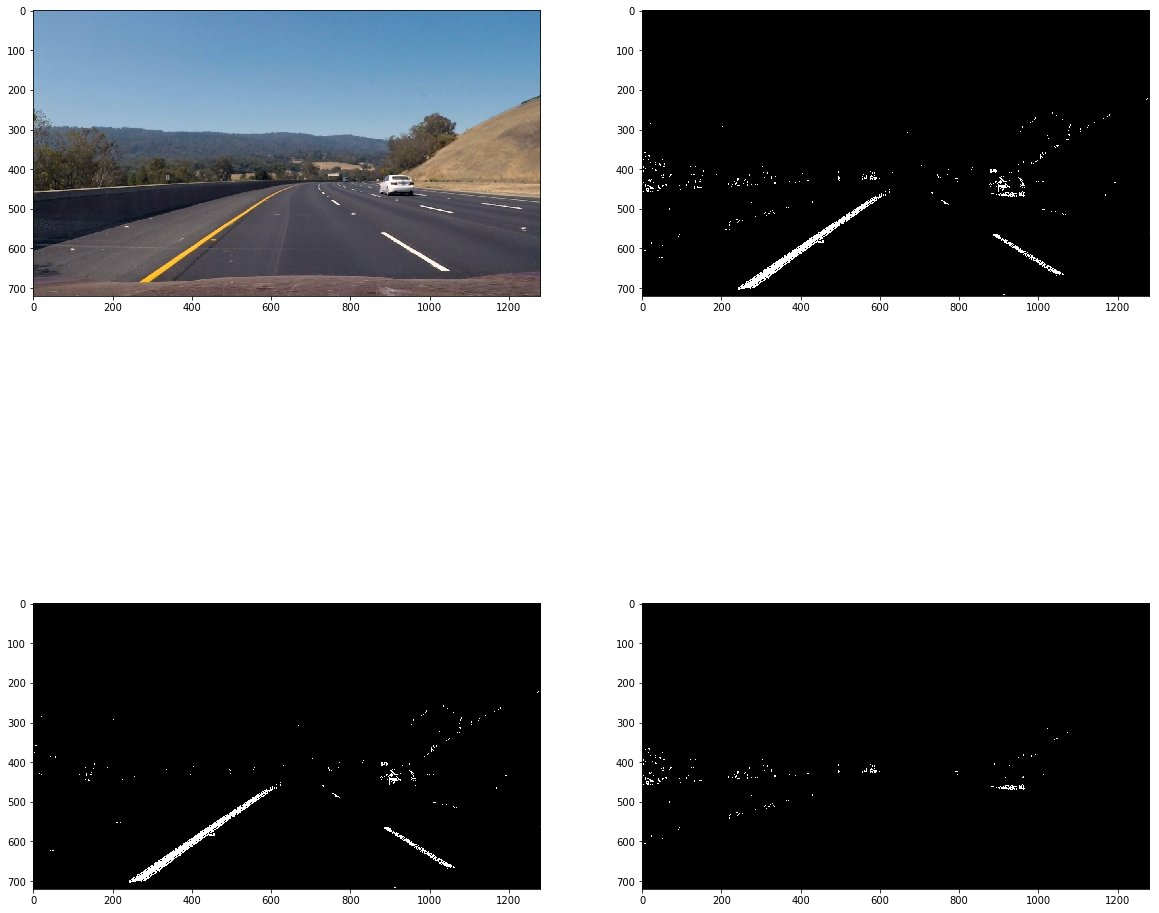

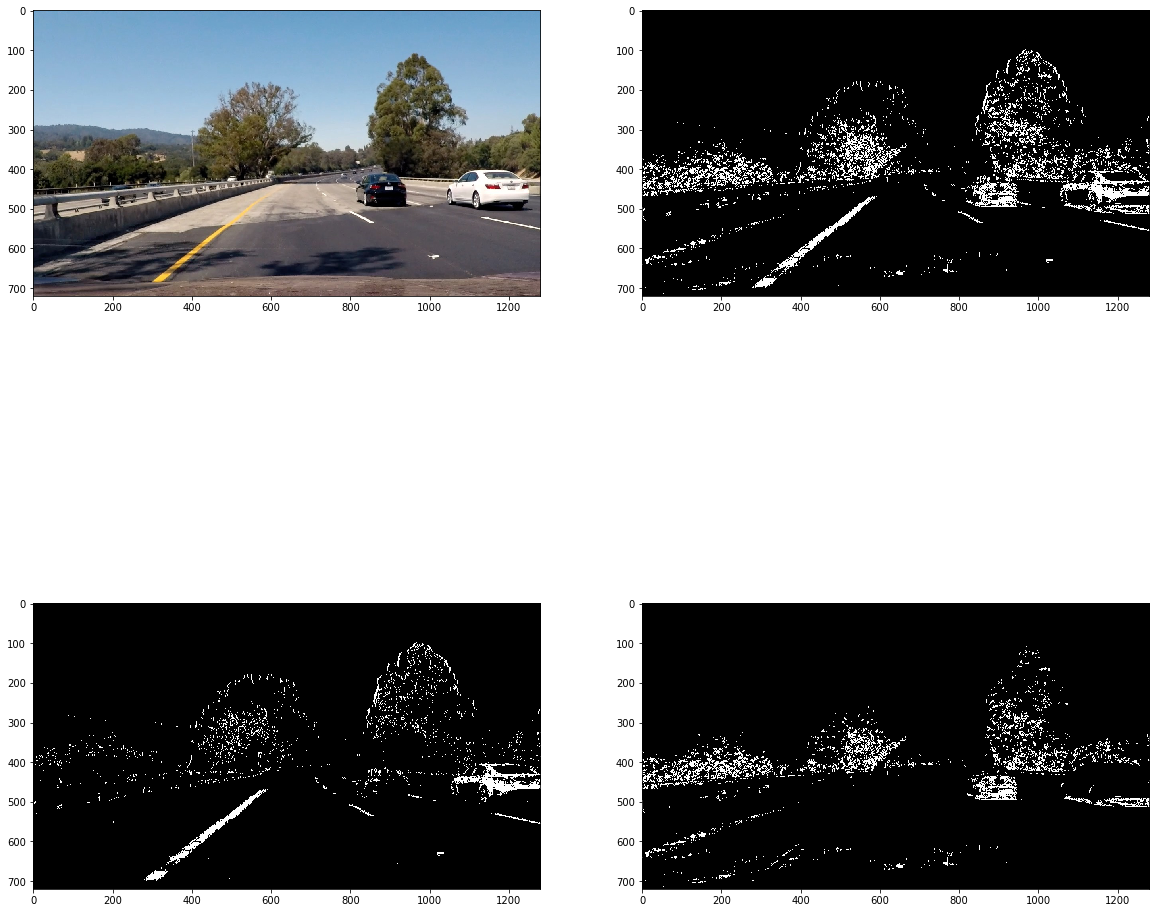

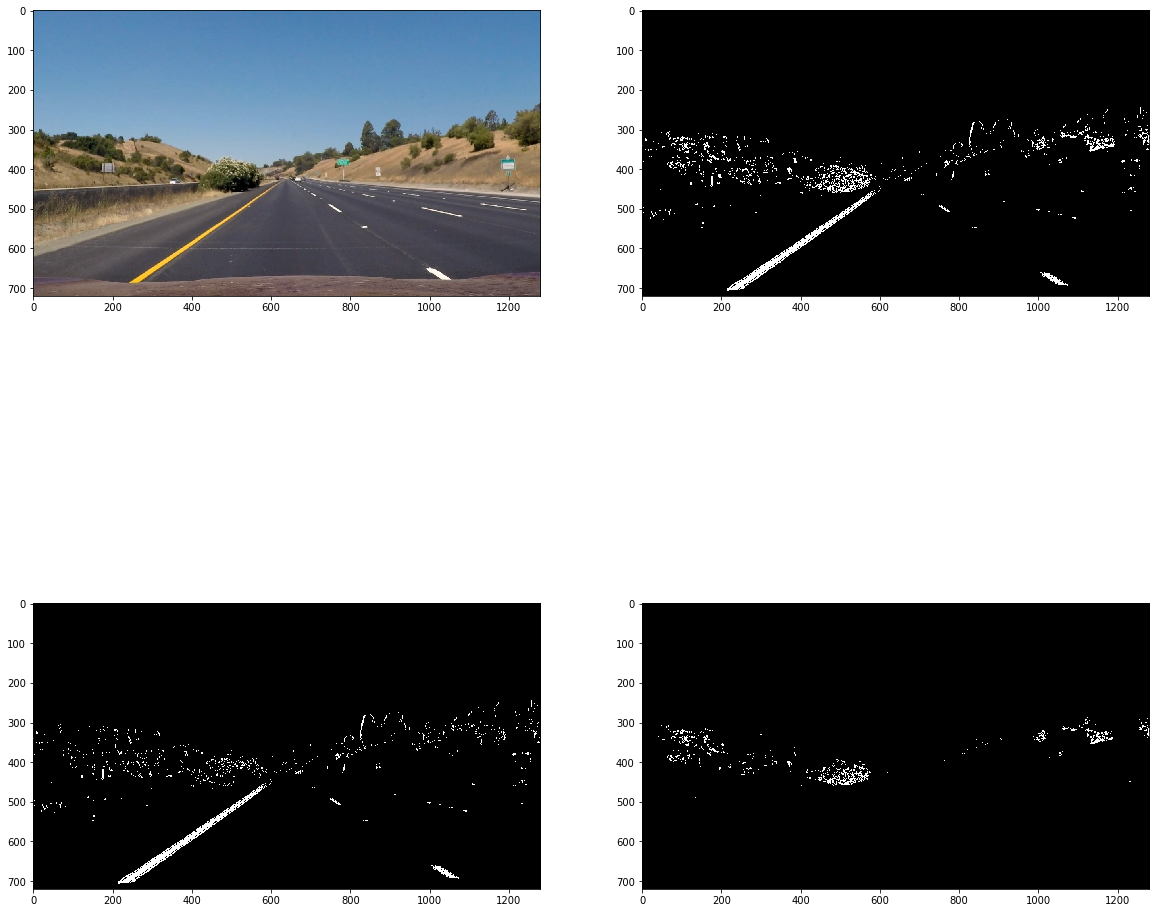

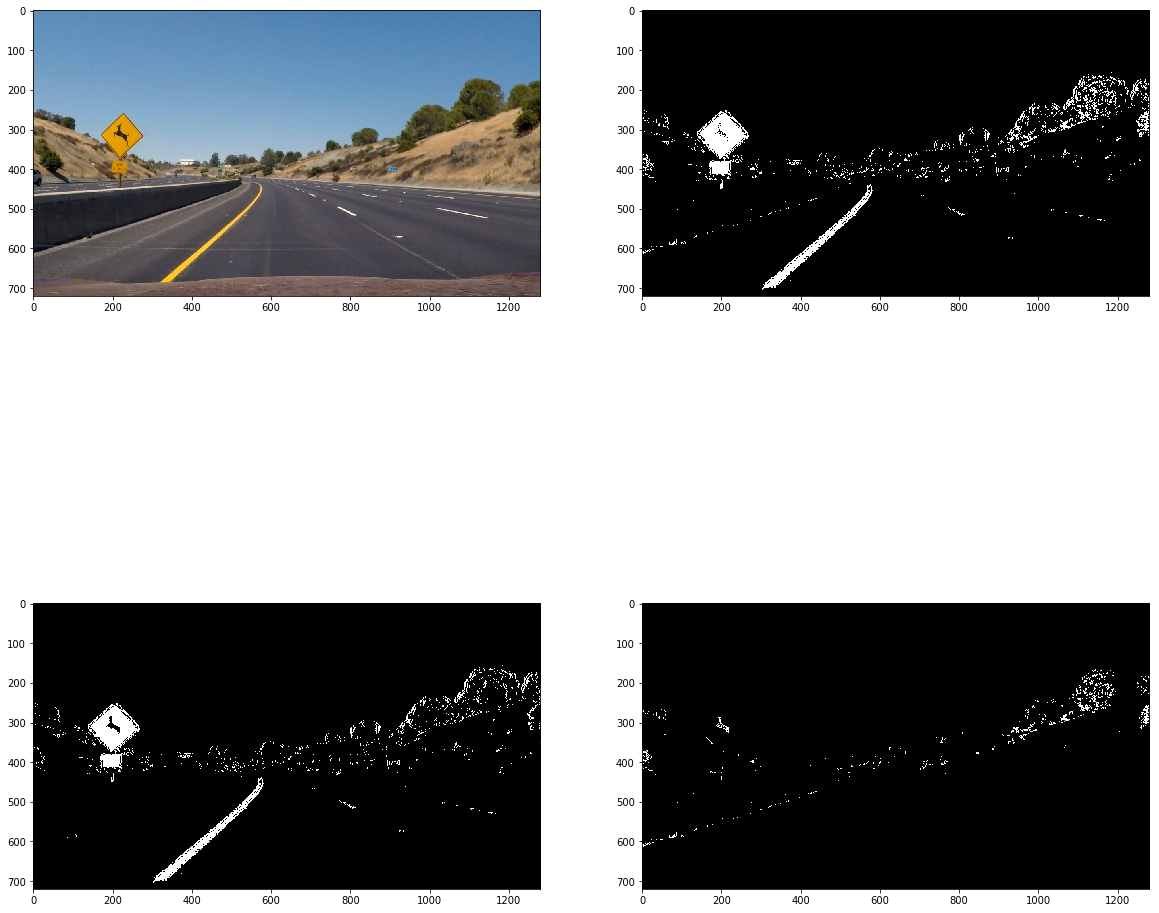

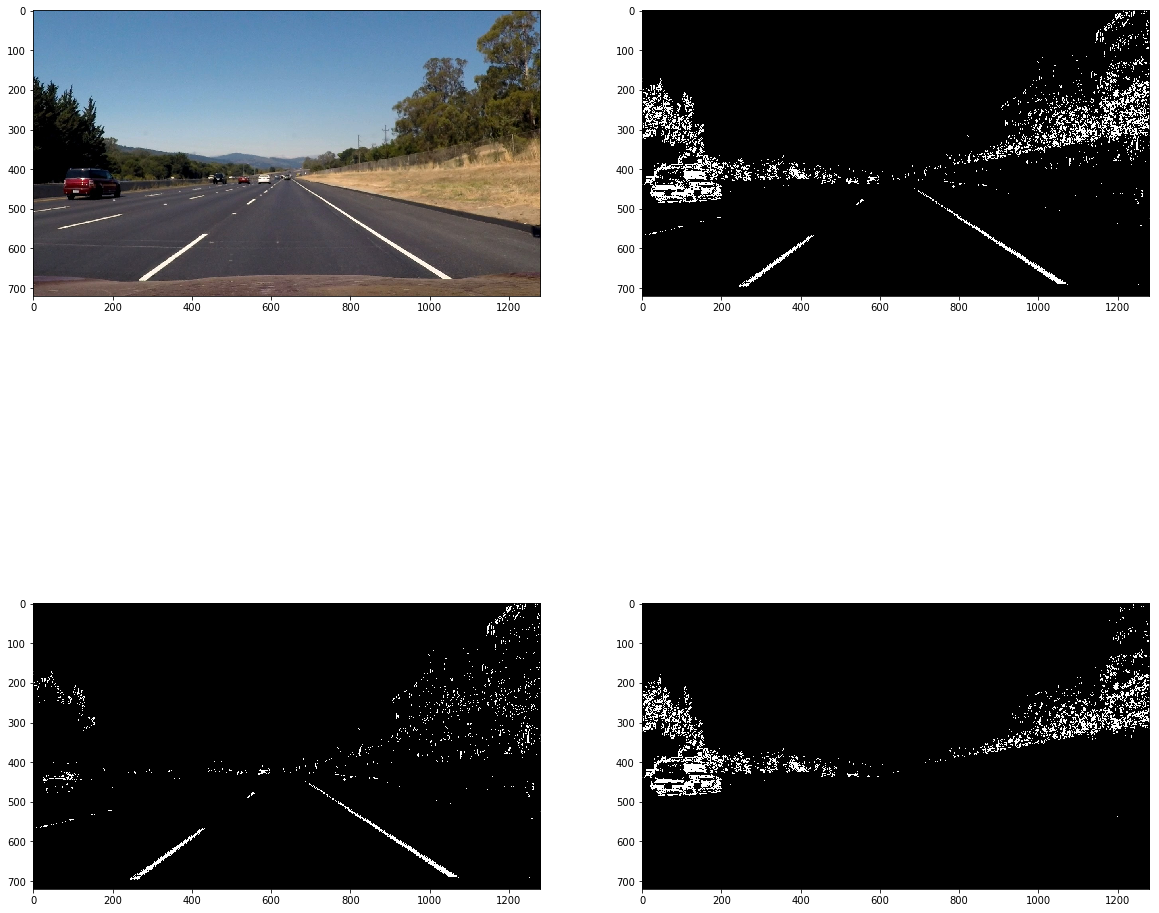

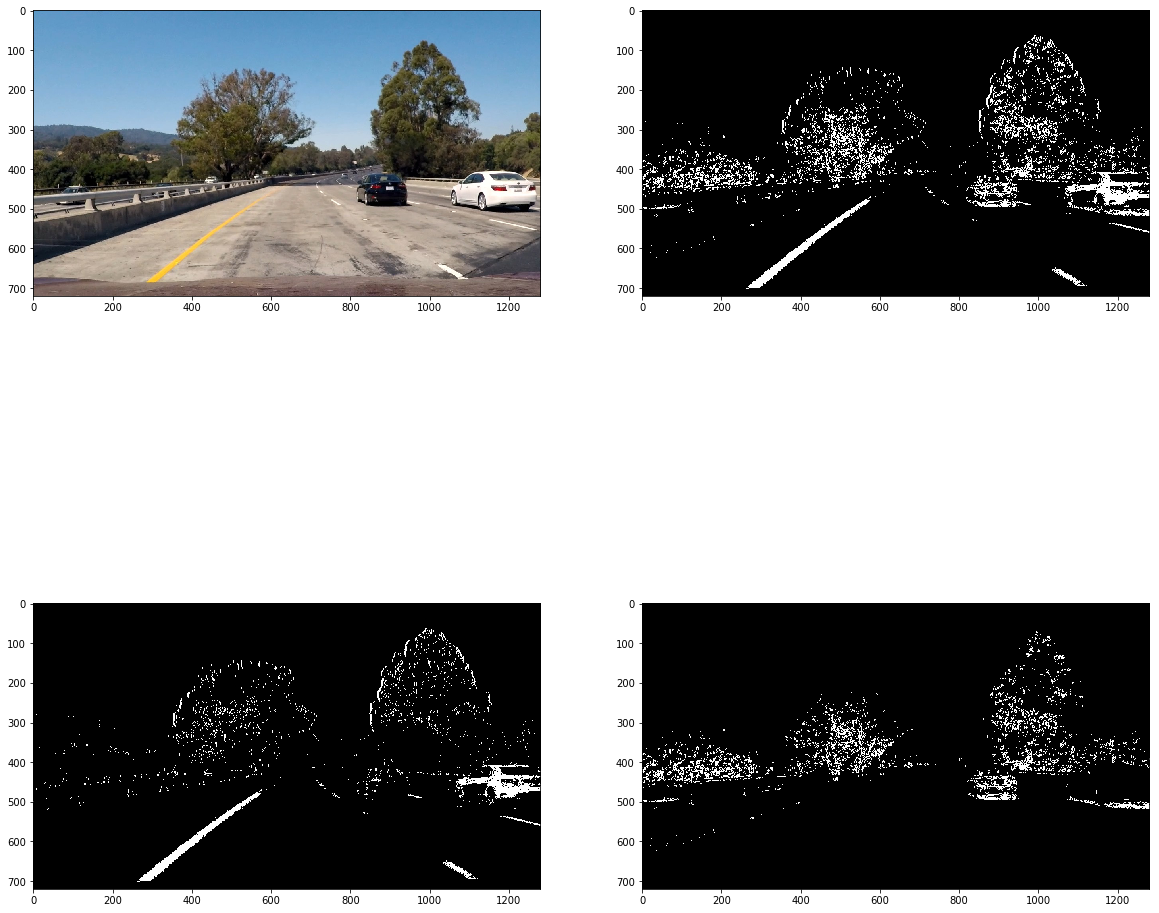

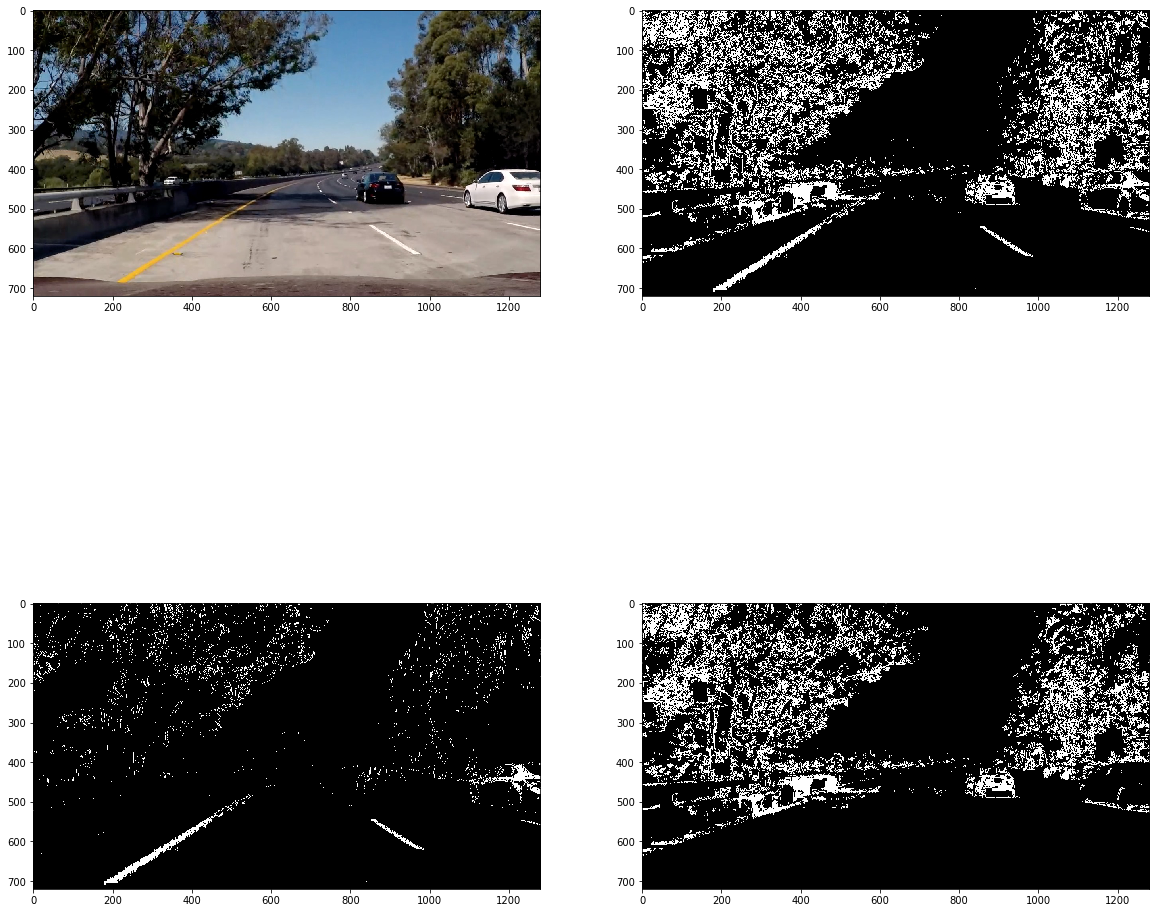

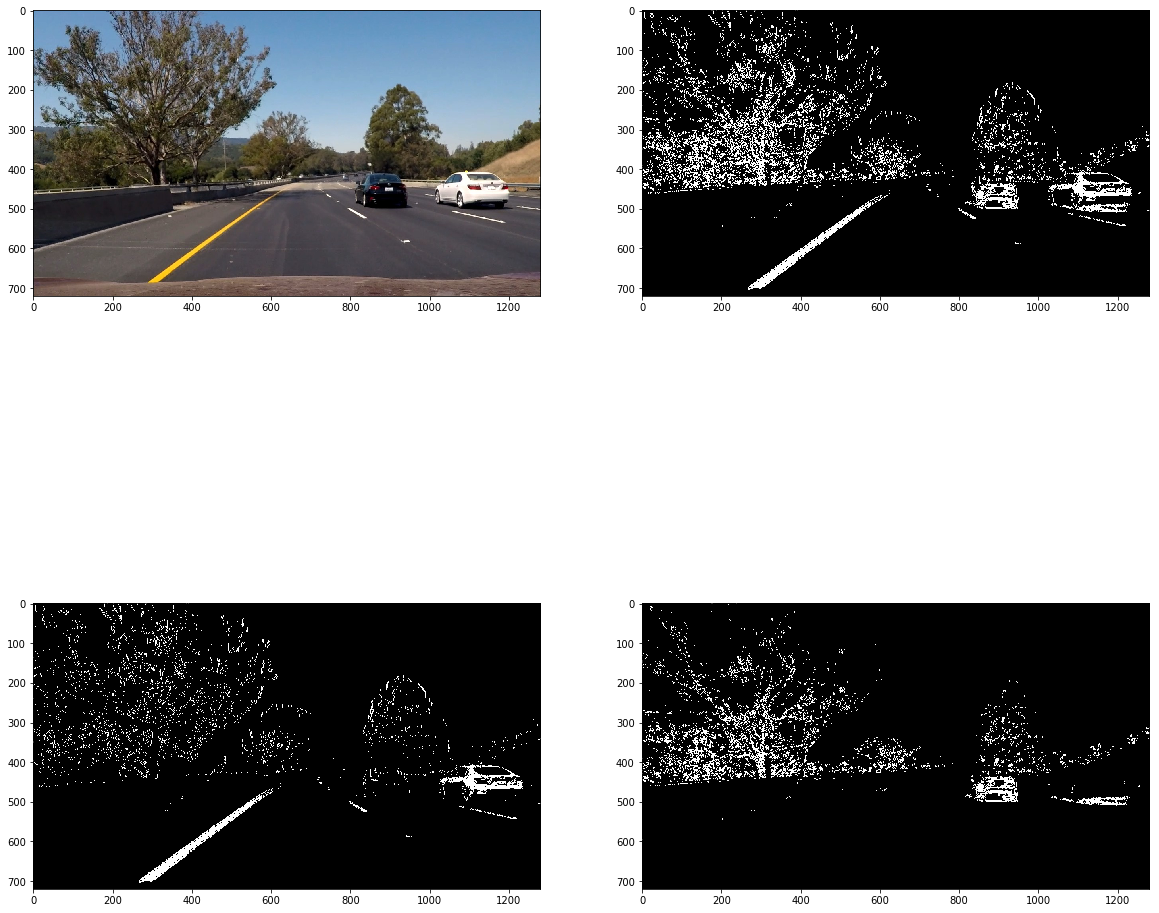

In [7]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def get_binary_filtered_img(path,mtx, dist, saturation_thresh=(170, 255), sobel_thresh=(20, 100), light_thresh=(0,80)):
    
    img = mpimg.imread(path)
    
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    # Apply the following steps to img
    # Convert to hls color space
    hls = cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    
    #calculating sobel for X
    sobel_x = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    # Take the absolute value of the derivative or gradient
    abs_sobel_x = np.absolute(sobel_x)
    
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= saturation_thresh[0]) & (s_channel <= saturation_thresh[1])] = 1
    
    light_binary = np.zeros_like(l_channel)
    light_binary[(l_channel >= light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, sobel_binary)) * 255
    combined_binary_1 = np.zeros_like(sobel_binary)
    combined_binary_1[(saturation_binary == 1) | (sobel_binary == 1)] = 1
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((saturation_binary == 1) | (sobel_binary == 1)) & (light_binary == 1)] = 1
    # 6) Return this mask as your binary_output image
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(2, 2, 1)
    plt.imshow(img)
    fig.add_subplot(2, 2, 2)
    plt.imshow(combined_binary_1, cmap= 'gray')
    fig.add_subplot(2, 2, 3)
    plt.imshow(combined_binary, cmap= 'gray')
    fig.add_subplot(2, 2, 4)
    plt.imshow((combined_binary - combined_binary_1), cmap= 'gray')
    return combined_binary

binary_images = {}

list_images = os.listdir("test_images/")
for file in list_images:
    path_image = "test_images/"+file
    f_binary_image = get_binary_filtered_img(path_image, mtx, dist, saturation_thresh=(180, 255), sobel_thresh=(20, 80), light_thresh=(50,255))
    binary_images["binary_"+file] = f_binary_image
    

#plt.imshow(grad_binary, cmap='gray')

In [8]:
#3.-PERSPECTIVE TRANSFORM

binary_test3.jpg
binary_test4.jpg
binary_straight_lines1.jpg
binary_test2.jpg
binary_straight_lines2.jpg
binary_test1.jpg
binary_test5.jpg
binary_test6.jpg


<Figure size 7200x7200 with 0 Axes>

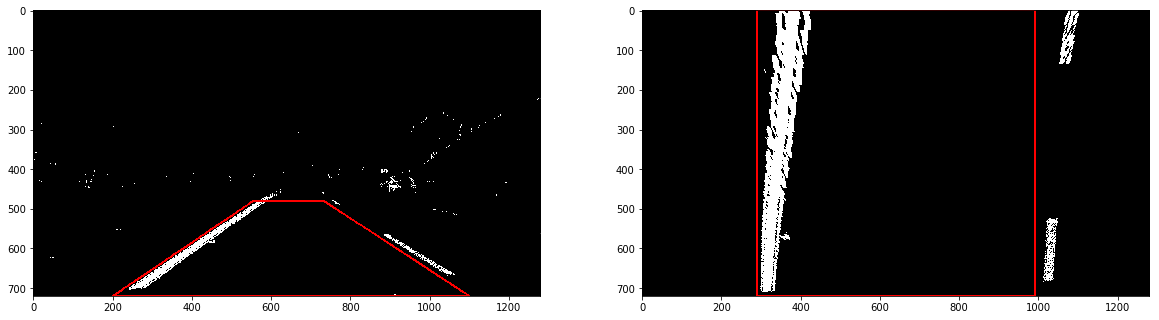

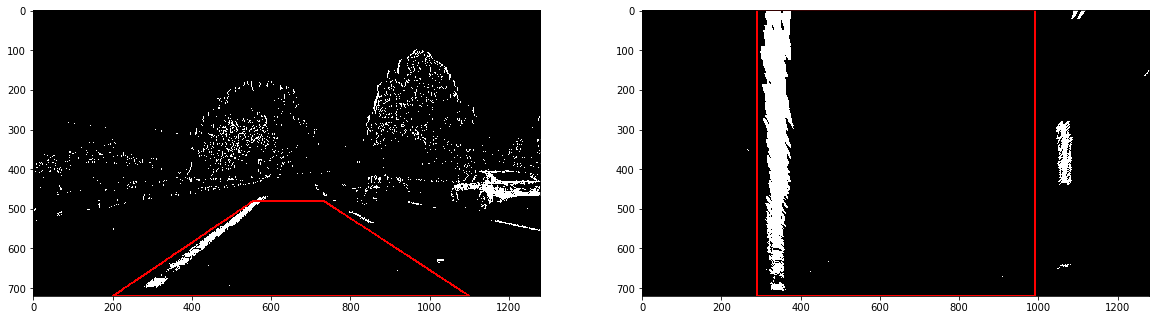

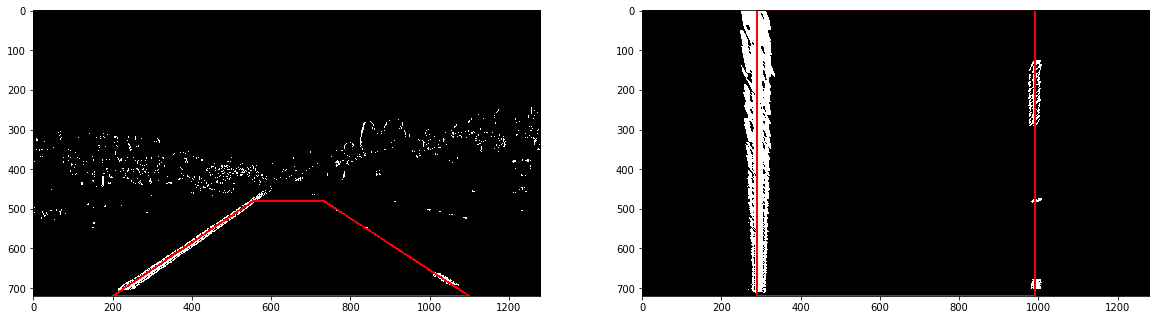

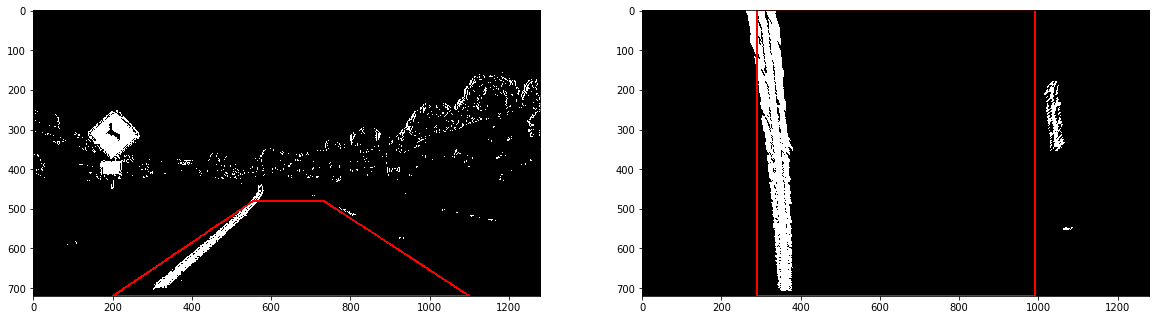

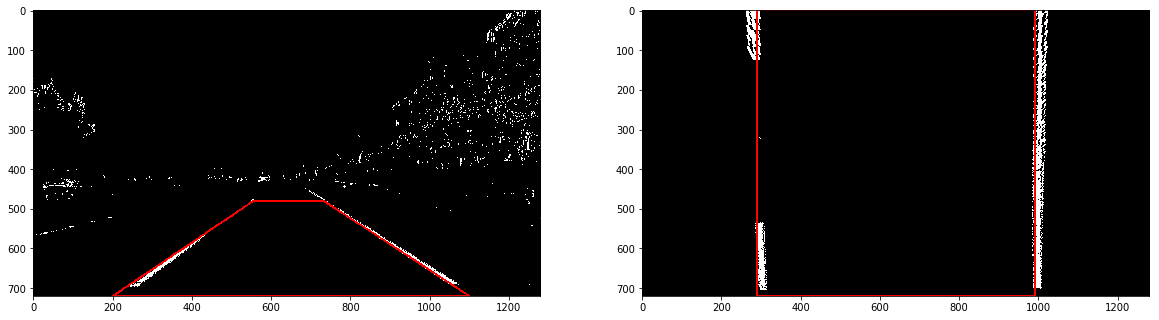

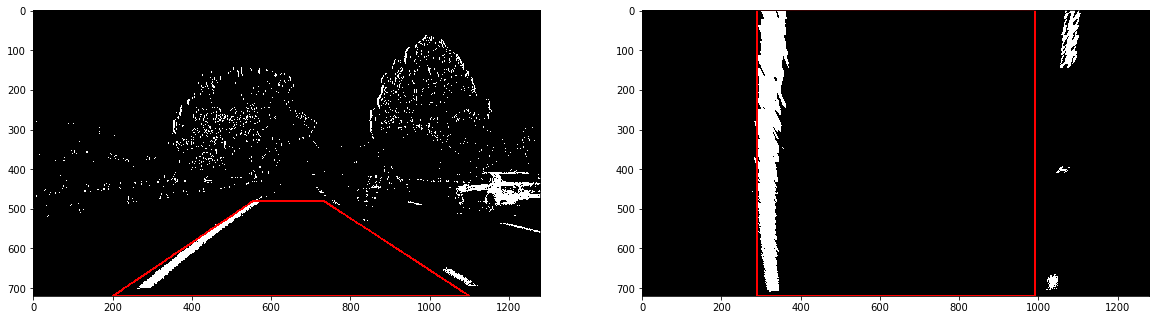

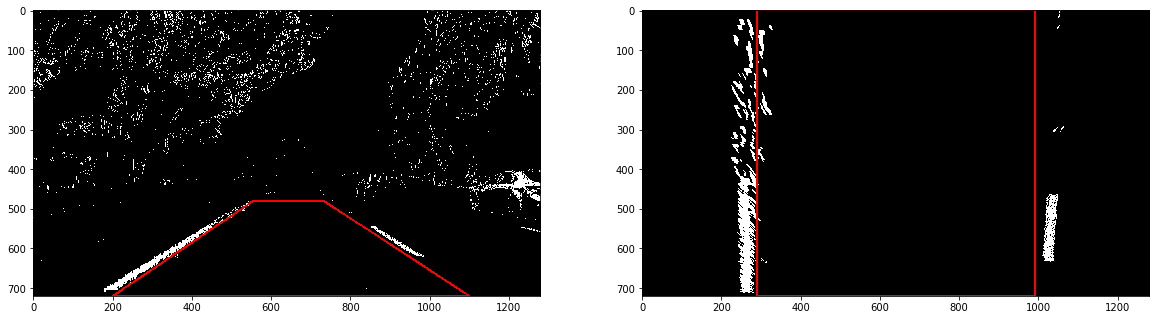

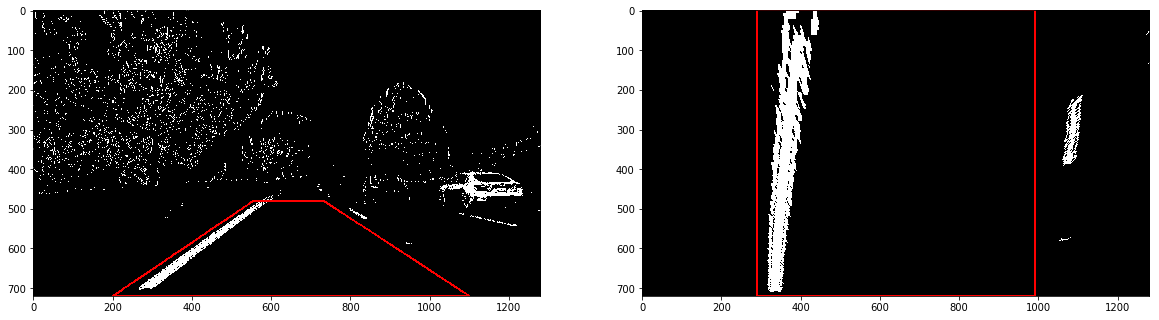

In [87]:
def prespective_transform(img, source_point, destination_point):
    
    #transforming binary image to 3d image for drawing color lines
    img_with_lines_s = np.dstack(( img, img, img))* 255
    
    #parameters for color lines
    color=[255, 0, 0]
    thickness=4
    
    
    #Drawings color lines for source
    cv2.line(img_with_lines_s, (source_point[0,0], source_point[0,1]), (source_point[1,0], source_point[1,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[1,0], source_point[1,1]), (source_point[2,0], source_point[2,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[2,0], source_point[2,1]), (source_point[3,0], source_point[3,1]), color, thickness)
    cv2.line(img_with_lines_s, (source_point[3,0], source_point[3,1]), (source_point[0,0], source_point[0,1]), color, thickness)
    
    
    img_size = (img.shape[1],img.shape[0])
    Warped_matrix = cv2.getPerspectiveTransform(source_point,destination_point)
    image_warpe = cv2.warpPerspective(img, Warped_matrix, img_size)
    
    #transforming binary image to 3d image for drawing color lines
    image_warpe_with_lines = np.dstack(( image_warpe, image_warpe, image_warpe))* 255
    
    #Drawings color lines for destination
    cv2.line(image_warpe_with_lines, (destination_point[0,0], destination_point[0,1]), (destination_point[1,0], destination_point[1,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[1,0], destination_point[1,1]), (destination_point[2,0], destination_point[2,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[2,0], destination_point[2,1]), (destination_point[3,0], destination_point[3,1]), color, thickness)
    cv2.line(image_warpe_with_lines, (destination_point[3,0], destination_point[3,1]), (destination_point[0,0], destination_point[0,1]), color, thickness)
    
    #print figures
    fig = plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img_with_lines_s, cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(image_warpe_with_lines, cmap='gray')
    #plt.show()
    
    return image_warpe

#Source points
x1_s = 200
x2_s = 555
x3_s = 732
x4_s = 1100
y_top_s = 720
y_low_s = 480
#generating the array for source points
src = np.float32([[x1_s, y_top_s],[x2_s, y_low_s],[x3_s, y_low_s],[x4_s, y_top_s]])

#destination points
x_low_d = 290
x_top_d = 990
y_top_d = 720
y_low_d = 0
#generating the array for destination points
dst = np.float32([[x_low_d, y_top_d],[x_low_d, y_low_d],[x_top_d, y_low_d],[x_top_d, y_top_d]])


fig = plt.figure(figsize=(100, 100))
for key, image in binary_images.items() :
    print (key)
    prespective_transform(image,src,dst)
    